# Clustering With Howso Engine

## Overview

This example notebook will demonstrate Howso Engine’s ability to calculate pairwise distances for the training cases. This capability is based on Howso Engine’s underlying instance-based learning platform. Distances can be used for a variety of use cases, in particular, for clustering algorithms, such as HDBSCAN. Howso Engine’s feature reduction capabilities will also be used to demonstrate how to eliminate features for clustering. 

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.cluster import HDBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import plot_umap

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

### Step 1: Generate a simple dataset with noise

A 2-D blob is generated along with an extra noise column. The noise column is used to demonstrate feature reduction.


In [2]:
blobs = make_blobs(n_samples=100, n_features=2, centers=[(1,0), (1,5), (10,2)], random_state=0)
df = pd.DataFrame(blobs[0], columns=['x', 'y'])
df['target'] = blobs[1]

# Noise
noise = np.random.uniform(df['y'].min(), df['y'].max(), len(df))
df['noise'] = noise

### Step 2: Create the Trainee, Train, and Analyze

For questions about the specific steps of this section, please see the [basic workflow guide](https://docs.howso.com/user_guide/basics/basic_workflow.html).

In [3]:
# Infer feature attributes
features = infer_feature_attributes(df)

# Specify Context and Action Features
action_features = ['target']

context_features = features.get_names(without=action_features)

# Create the Trainee
t = engine.Trainee(features=features, overwrite_existing=True)

# Train
t.train(df)

# Targeted Analysis
t.analyze(context_features=context_features, action_features=action_features)

### Step 3: Inspect Feature Importance

In this example, since we have a target variable, we can inspect the feature contributions and feature [Mean Decrease in Accuracy](https://docs.howso.com/getting_started/terminology.html#mda) (MDA) to understand how important each feature is.

In [4]:
robust_feature_influences = t.get_prediction_stats(
    context_features=context_features,
    action_feature=action_features[0],
    details={
        "feature_contributions_robust": True,
        "feature_mda_robust": True
    }
)
robust_feature_influences

,y,noise,x
feature_mda_robust,0.142577,-0.041198,0.071194
feature_contributions_robust,0.309129,0.138734,0.241962
directional_feature_contributions_robust,0.277020,-0.123838,0.196681


We can see that the noise column not only contributes less to the prediction than the other variables, but it also marginally increases (and perhaps lowers) the accuracy. This is expected from the noise column and demonstrates how unimportant features can be highlighted with Howso Engine.

### Step 4: Remove Unuseful Features

Unuseful features like the noise feature can reduce the quality of the clustering so we will remove them in this example. Howso Engine allows use to easily remove the features from the Trainee.

In [5]:
# Remove the noise feature
t.remove_feature('noise')

# update context_features
context_features.remove('noise')

# Reanalyze with the remaining features
t.analyze(context_features=context_features, action_features=action_features)

## Step 5: Get pairwise distances

By directly using Howso Engine's pairwise distances, we can take advantage of all the benefits of Howso Engine, including the ease of preprocessing and categorical variable handling. 

`get_distances` returns a square matrix of distances that make up the pairwise distances from each case to each other case in the model. The distances are computing using the Howso Engine's internal distance metric which has its parameters tuned within the Analyze call. For more information about the Howso Engine's distance metric, see [<em>Surprisal Driven k-NN for Robust and Interpretable Nonparametric Learning </em> (Banerjee et. al. 2023)](https://arxiv.org/abs/2311.10246).

In [6]:
# Pairwise distances can be obtained with a call to `get_distances`
x = t.get_distances()

x['distances']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,107306.868785,83.801670,144109.828560,147535.703594,1256.448809,158.543462,163238.764868,100278.410706,1752.522346,...,912.879451,80237.198035,96942.101029,151233.024789,263.153237,116221.577910,170762.757400,38534.485772,92711.426634,85920.547745
1,107306.868785,0.000000,103536.404626,1082.472688,717.678704,137989.916302,75717.113958,236.819716,202523.744176,173013.148662,...,39594.816973,220245.023423,215620.354714,1563.808467,50502.665883,241096.630141,1050.946314,220948.525747,205196.460920,211303.913768
2,83.801670,103536.404626,0.000000,146795.115456,150273.686816,1340.303817,298.654630,165638.572073,103592.433083,1750.554567,...,883.430361,75837.170421,94852.221478,153703.137217,116.910946,114054.438193,173019.920525,46982.842074,96423.662878,90292.885614
3,144109.828560,1082.472688,146795.115456,0.000000,170.943349,96403.778851,163021.013275,554.376312,161223.736801,69490.507414,...,148051.819435,178313.535723,168945.218790,396.339611,159189.592193,202840.678741,479.791627,181246.878967,163719.572982,171029.257038
4,147535.703594,717.678704,150273.686816,170.943349,0.000000,98238.478046,167185.146235,360.456513,167447.526616,64127.605439,...,152616.372087,184095.841430,174338.693473,683.770307,163128.533013,208726.649113,733.124547,187303.498184,169860.094907,177203.883357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,116221.577910,241096.630141,114054.438193,202840.678741,208726.649113,137626.285740,122628.155342,195228.676172,1714.055762,83919.465366,...,153193.499232,892.303378,618.304472,192843.661307,116900.610226,0.000000,184312.572213,909.384768,1605.017180,1328.922198
96,170762.757400,1050.946314,173019.920525,479.791627,733.124547,134766.435860,185491.498334,358.677817,138895.472301,140561.000371,...,170264.555263,155783.560318,140672.584223,641.295115,182708.203683,184312.572213,0.000000,161076.505929,141267.658956,150077.905545
97,38534.485772,220948.525747,46982.842074,181246.878967,187303.498184,106214.630951,47296.349054,172879.210506,804.659649,110618.202977,...,119800.669417,399.025482,1012.983572,170714.179759,52632.768944,909.384768,161076.505929,0.000000,693.486322,418.451630
98,92711.426634,205196.460920,96423.662878,163719.572982,169860.094907,76142.865585,97558.684863,154248.858556,82.746903,117845.753646,...,86629.905269,549.388166,923.005760,152568.682473,100882.049871,1605.017180,141267.658956,693.486322,0.000000,255.105761


## Step 6a: Cluster

Having access to the full matrix of pairwise distances, users have the ability to cluster with whatever algorithm they prefer (provided it supports a matrix of precomputed pairwise distances as an input).

In the case of this recipe, we demonstrate using the HDBSCAN provided through Scikit-Learn.

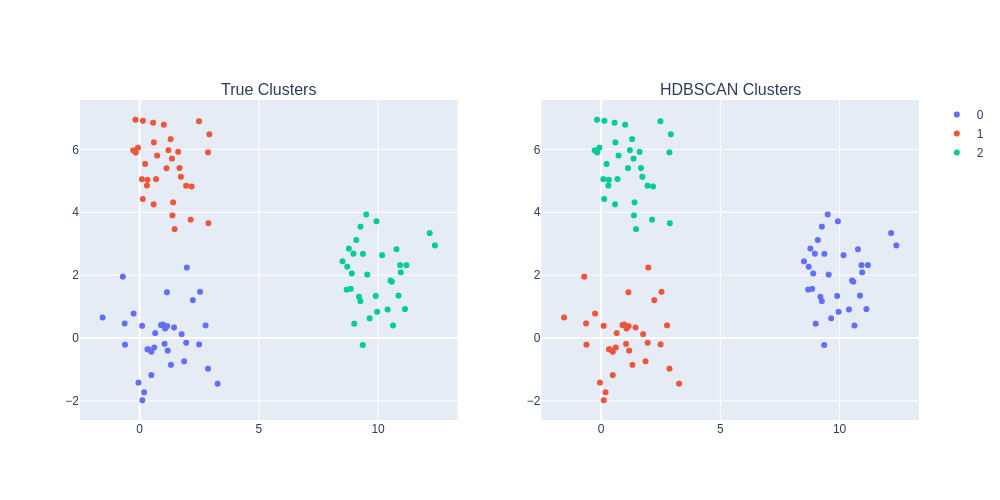

In [7]:
hdb = HDBSCAN(min_cluster_size=15, max_cluster_size=50, min_samples=10, metric='precomputed').fit(x['distances'])
hdbscan_labels = hdb.labels_
df["hdbscan_labels"] = hdbscan_labels

fig = make_subplots(rows=1, cols=2, subplot_titles=["True Clusters", "HDBSCAN Clusters"])
for label, group in df.groupby("target"):
    fig.add_scatter(x=group.x, y=group.y, col=1, row=1, mode="markers", name=label)
for label, group in df.groupby("hdbscan_labels"):
    fig.add_scatter(
        x=group.x, y=group.y, col=2, row=1, mode="markers", name=label,
        marker_color=fig.layout["template"]["layout"]["colorway"][label],
        showlegend=False
    )
fig.update_layout(width=1000)
fig.show()

## Step 6b: Visualize with UMAP

UMAP can be used in tandem with Howso Engine to visualize high-dimensional datasets, similar to how HDBSCAN is used.

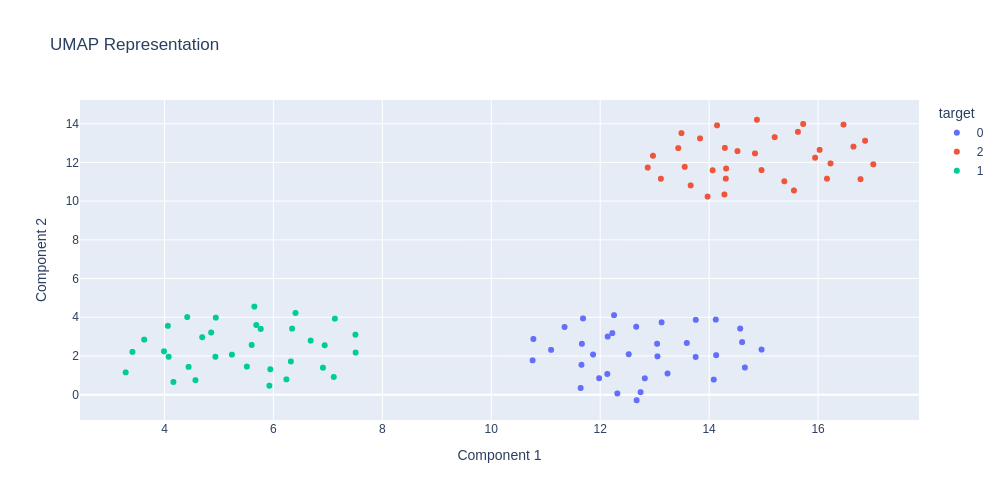

In [8]:
fig = plot_umap(t, color="target", action_feature=action_features[0])
fig.update_layout(width=1000)
fig.show()

## Step 7: Inspect Accuracy 

We calculate the performance of the clustering by measuring the similarity of the clusters compared to the original labels.

In [9]:
dist_contribution_acc = adjusted_rand_score(df['target'], hdbscan_labels)
print(f'clustering accuracy score: {dist_contribution_acc}')

clustering accuracy score: 1.0


# Conclusion

As we demonstrate here, it is quite simple to use the Howso Engine for clustering using the internal distance metric by retrieving the pairwise distance matrix with `get_distances`. This pairwise distance metric can be passed to many popular clustering algorithms.